In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

In [16]:
df = pd.read_csv(f'./data/combined.csv')
df_gesamt = df[df['Age'] == 'gesamt']
df_gesamt['Date'] = pd.to_datetime(df_gesamt['Year'].astype(str) + df_gesamt['Week'].astype(str).str.zfill(2) + '1', format='%Y%W%w')
df_gesamt= df_gesamt.drop(columns=['Year','Week','Age'])
df_gesamt.set_index(['Date'],inplace = True)
df_gesamt = df_gesamt.fillna(0)
df_gesamt = df_gesamt[['Value_Covid']]

df_policy = pd.read_csv(f'./data/Policy_Weekly_Extended.csv')
df_policy['Date'] = pd.to_datetime(df_policy['Year'].astype(str) + df_policy['Week'].astype(str).str.zfill(2) + '1', format='%Y%W%w')
df_policy = df_policy.drop(columns=['Year','Week'])
df_policy.set_index(['Date'],inplace = True)
df_policy = df_policy.fillna(0)
df_policy = df_policy[['C1E_School closing','C2E_Workplace closing','C3E_Cancel public events','C4E_Restrictions on gatherings','C5E_Close public transport','C6E_Stay at home requirements','C7E_Restrictions on internal movement']]*1000

df_gesamt = df_policy.merge(df_gesamt, on='Date', how='left')
split = int(0.4*len(df_gesamt))
df_gesamt = df_gesamt[:split]
df_diff = df_gesamt.diff().dropna()
model = VAR(df_diff)
results = model.fit(maxlags=2, ic='aic')

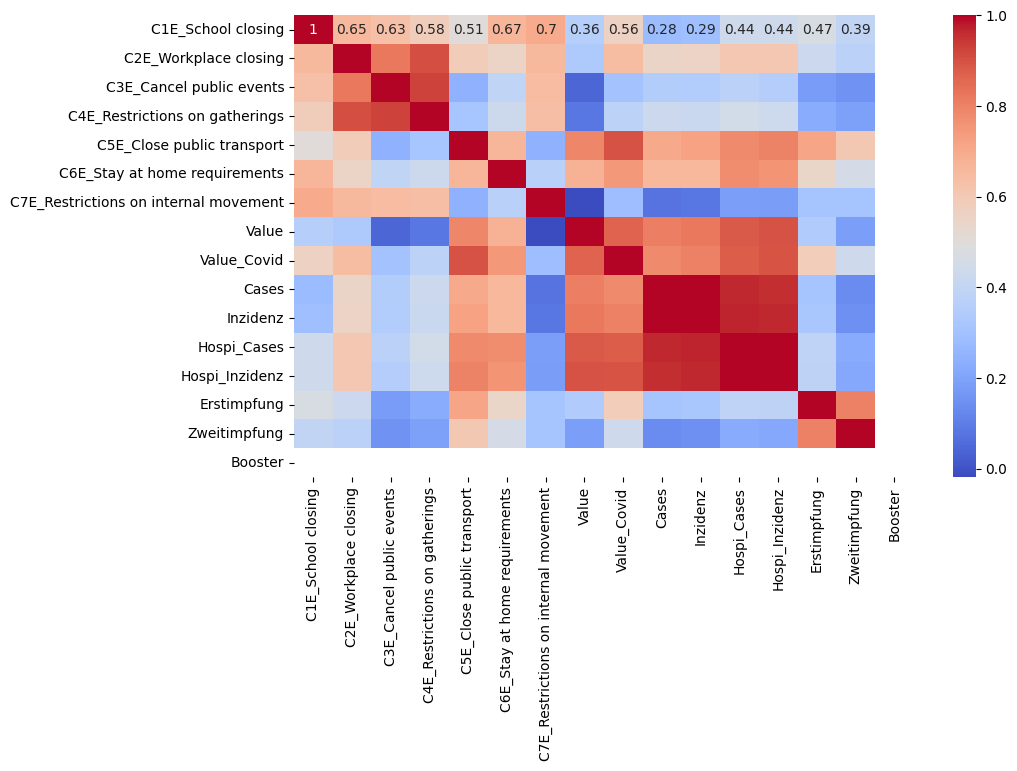

In [17]:
corr_matrix = df_gesamt.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [17]:
lag_order = results.k_ar
forecast_steps = 10
forecast = results.forecast(df_diff.values[-lag_order:], steps = forecast_steps)
forecast_df = pd.DataFrame(forecast, index = pd.date_range(start=df_gesamt.index[-1], periods=forecast_steps+1, freq='D')[1:],columns = df_gesamt.columns)
for column in df_gesamt.columns:
    forecast_df[column] = df_gesamt[column].iloc[-1] + forecast_df[column].cumsum()

combined_df = pd.concat([df_gesamt,forecast_df])


fig = go.Figure()
for column in df_gesamt.columns:
    fig.add_trace(go.Scatter(
        x=combined_df.index, 
        y=combined_df[column], 
        mode='lines', 
        name=f'Observed {column}'
    ))
    fig.add_trace(go.Scatter(
        x=forecast_df.index, 
        y=forecast_df[column], 
        mode='lines', 
        name= f'Forecast {column}'
    ))


fig.update_layout(
    title='VAR(Vector Autoregression)',
    xaxis_title='Year',
    yaxis_title='Metric'
)
fig.show()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[2]             : AIC=7071.928, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[2]             : AIC=6970.595, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[2]             : AIC=inf, Time=0.06 sec
 ARIMA(1,1,0)(0,1,0)[2]             : AIC=7071.180, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[2]             : AIC=6947.175, Time=0.05 sec
 ARIMA(1,1,0)(3,1,0)[2]             : AIC=6929.173, Time=0.16 sec
 ARIMA(1,1,0)(4,1,0)[2]             : AIC=6910.428, Time=0.28 sec
 ARIMA(1,1,0)(5,1,0)[2]             : AIC=6897.781, Time=0.38 sec
 ARIMA(1,1,0)(6,1,0)[2]             : AIC=6897.633, Time=0.37 sec
 ARIMA(1,1,0)(7,1,0)[2]             : AIC=6895.025, Time=0.47 sec
 ARIMA(1,1,0)(8,1,0)[2]             : AIC=6890.037, Time=0.53 sec
 ARIMA(1,1,0)(9,1,0)[2]             : AIC=6887.737, Time=0.66 sec
 ARIMA(1,1,0)(10,1,0)[2]             : AIC=6884.454, Time=0.97 sec
 ARIMA(1,1,0)(10,1,1)[2]             : AIC=inf, Time=3.31 sec
 ARIMA(1,1,0)(9,1,1)[2]             : AIC

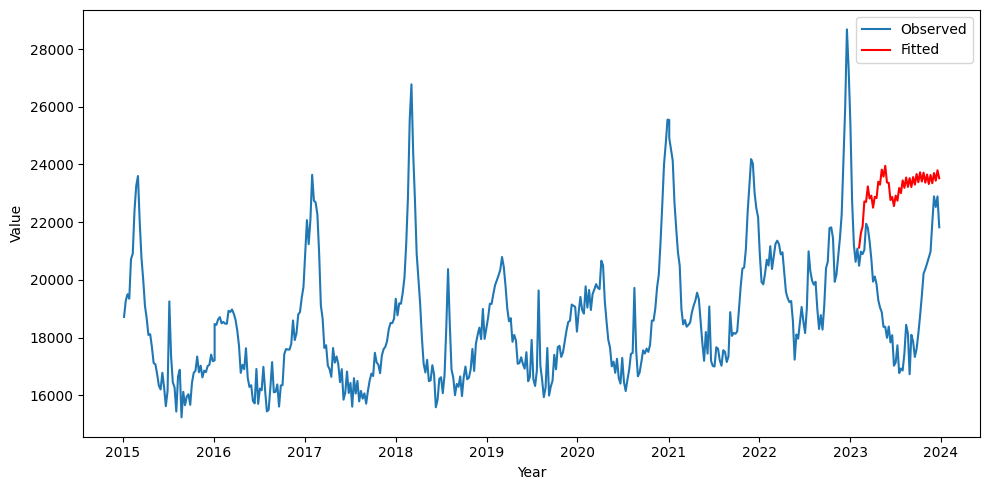

<class 'pmdarima.arima.arima.ARIMA'>


AttributeError: 'ARIMA' object has no attribute 'get_forecast'

In [14]:
import pmdarima as pm
import pandas as pd
df = pd.read_csv(f'./data/combined.csv')
df_gesamt = df[df['Age'] == 'gesamt']
df_gesamt['Date'] = pd.to_datetime(df_gesamt['Year'].astype(str) + df_gesamt['Week'].astype(str).str.zfill(2) + '1', format='%Y%W%w')
df_gesamt= df_gesamt.drop(columns=['Year','Week','Age'])
df_gesamt.set_index(['Date'],inplace = True)
df_gesamt = df_gesamt.fillna(0)
timeseries = df_gesamt['Value']
split = int(0.9*len(timeseries))
train, test = timeseries[:split], timeseries[split:]
model = pm.auto_arima(train, 
                      start_p=0, start_q=0,
                      test='adf',       # Use adftest to find optimal 'd'
                      max_p=5, max_q=5, max_d=3, # Maximum p and q
                      m=2,             # Seasonality
                      start_P=0, start_Q=0,
                      max_P=10, max_Q=10, max_D=3, # Maximum p and q
                      seasonal=True,    # Seasonal ARIMA
                      d=1,           # Let model determine 'd'
                      D=1,              # Seasonal difference
                      trace=True,       # Print status on the fits
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)    # Stepwise search to find the best model

# Summarize the model
print(model.summary())

# Frecast future values
forecast = model.predict(n_periods=len(test))
forecast.index = test.index
print(forecast)
plt.figure(figsize=(10, 5))
plt.plot(timeseries.index, timeseries, label='Observed')
plt.plot(forecast.index, forecast, label='Fitted', color='red')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()
#print(f"MSE: {mse(monthly_temp['temp'][:split],monthly_temp['forecast'][:split]):.2f}")
print(type(model))
results = model

forecast_steps = 10
forecast = results.get_forecast(steps=forecast_steps)
print(forecast.predicted_mean.reset_index(drop=True))
forecast_index = np.arange(df.index[-1] + 1, df.index[-1] + 1 + forecast_steps)
print(forecast_index)
forecast_df = pd.DataFrame({'Year':forecast_index,'Forecast': forecast.predicted_mean.reset_index(drop=True)})
forecast_df = forecast_df.set_index('Year')
plt.figure(figsize=(10, 5))
plt.plot(df.index, df, label='Observed')
plt.plot(df.index, forecast_df['Forecast'], label='Forecast', color='red')
plt.fill_between(df.index,forecast.conf_int().iloc[:, 0],forecast.conf_int().iloc[:, 1],color='pink', alpha=0.3)
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.show()

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
split = int(0.55*len(timeseries))#0.986 #0.7817
train, test = timeseries[:split], timeseries[split:]
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
results = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.62217D+00    |proj g|=  1.57664D-01


 This problem is unconstrained.



At iterate    5    f=  6.57630D+00    |proj g|=  4.32325D-02

At iterate   10    f=  6.57342D+00    |proj g|=  2.10272D-04

At iterate   15    f=  6.57340D+00    |proj g|=  3.50044D-03

At iterate   20    f=  6.57281D+00    |proj g|=  2.82642D-02

At iterate   25    f=  6.56485D+00    |proj g|=  7.06453D-03

At iterate   30    f=  6.55972D+00    |proj g|=  1.34481D-03

At iterate   35    f=  6.52967D+00    |proj g|=  1.18357D-02

At iterate   40    f=  6.52841D+00    |proj g|=  5.39516D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     50      1     0     0   1.837D-06   6.528D+00
  F =   6.52840567895

In [27]:
forecast = 52
pred_summary = results.get_prediction(0, len(timeseries.index)+forecast).summary_frame()
display(pred_summary.index)
plot_ci = False
pre_test = 200
display(timeseries)
timeseries_cut = timeseries[split-pre_test:]
display(timeseries_cut)
pred_summary_cut = pred_summary[split-pre_test:]
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=timeseries_cut.index, 
    y=timeseries_cut, 
    mode='lines', 
    name='Ground Truth'
))
fig.add_trace(go.Scatter(
    x=timeseries_cut.index, 
    y=pred_summary_cut['mean'], 
    mode='lines', 
    name='Prediction'
))
if plot_ci:
    fig.add_trace(go.Scatter(
        x=timeseries_cut.index, 
        y=pred_summary_cut['mean_ci_lower'], 
        fill=None,
        mode='lines',
        line=dict(color='lightgrey'),
        showlegend=False
    ))
    fig.add_trace(go.Scatter(
        x=timeseries_cut.index, 
        y=pred_summary_cut['mean_ci_upper'], 
        fill='tonexty',  # fill area between trace_ci_lower and trace_ci_upper
        mode='lines',
        line=dict(color='lightgrey'),
        showlegend=False
    ))
fig.add_shape(
    dict(
        type="line",
        x0=test.index[0],
        y0=timeseries_cut.min(),  # Set y0 to a value within the plot's range
        x1=test.index[0],
        y1=timeseries_cut.max(),  # Set y1 to a value within the plot's range
        line=dict(
            color="Black",
            width=2,
            dash="dashdot",
        )
    )
)

fig.update_layout(
    title='Sarima on weekly Deaths',
    xaxis_title='Year',
    yaxis_title='Deaths'
)
fig.show()

RangeIndex(start=0, stop=523, step=1)

Date
2015-01-05    18713.0
2015-01-12    19283.0
2015-01-19    19500.0
2015-01-26    19346.0
2015-02-02    20716.0
               ...   
2023-11-27    21975.0
2023-12-04    22894.0
2023-12-11    22528.0
2023-12-18    22890.0
2023-12-25    21822.0
Name: Value, Length: 470, dtype: float64

Date
2016-02-08    18541.0
2016-02-15    18483.0
2016-02-22    18475.0
2016-02-29    18926.0
2016-03-07    18888.0
               ...   
2023-11-27    21975.0
2023-12-04    22894.0
2023-12-11    22528.0
2023-12-18    22890.0
2023-12-25    21822.0
Name: Value, Length: 412, dtype: float64